<h1>Baseline</h1>
<p>
    This control model will uses data from a window of time to predict the value of cryptocurrency.
</p>

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import random
from typing import Literal
import math as ma
from sklearn.model_selection import train_test_split

%matplotlib inline

In [88]:
def get_csv(path: str) -> pd.DataFrame:

    return pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price', '24h High (USD)': 'high', '24h Low (USD)': 'low'})

    
def MAPE(pred, real) -> float:
    return np.mean(abs(1 - (pred / real)))


def RMSE(pred, real) -> float:
    return np.sqrt(np.mean((real - pred) ** 2))
    

def MSE(pred, real) -> float:
    return np.mean((real - pred) ** 2)


def plot_graph(*args, title: str = None, colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], **kwargs) -> None:

    plt.figure(figsize = (20, 6))
    number_of_graph = 0
    
    if title is not None:
        plt.title(title)

    for arg in args:
        plt.plot(arg, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    for kw in kwargs:
        plt.plot(kwargs[kw], label = kw, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    if len(kwargs) > 0:
        plt.legend(loc = 'best')

    plt.show()

In [89]:
df_ada = get_csv('./data/cardano.csv')

<h3>Implementing Control Regression</h3>
<p>
    Below is the implementation of Control regression if the form of a python class. The class method and naming mimic the Scikit-learn models.
</p>

In [93]:
class ControlRegression:
    
    def __init__(self, strategy: Literal['mean', 'constant', 'random', 'median', 'mode'] = 'random', constant = None, seed: float = None):

        if strategy not in ['mean', 'constant', 'random', 'median']:
            raise ValueError(f'Unknown strategy type: {strategy}, expected one of (\'mean\', \'median\', \'quantile\', \'constant\').')

        if strategy == 'constant' and constant is None:
            raise TypeError('Constant value has to be specified when the constant strategy is used.')

        if strategy == 'random' and seed is None:
            raise TypeError('Seed value has to be specified when the random strategy is used.')

        self.__strategy = strategy
        self.__constant = constant
        self.__seed = seed

    def fit(self, x: pd.DataFrame, y: np.ndarray) -> None:
        self.__train_y = y

    def predict(self, x: pd.DataFrame) -> np.ndarray:

        if self.__strategy == 'mean':
            return np.array([np.mean(self.__train_y) for _ in x.index])

        elif self.__strategy == 'constant':
            return np.array([self.__constant for _ in x.index])

        elif self.__strategy == 'random':
            return np.array([random() * self.__seed for _ in x.index])

        elif self.__strategy == 'median':
            return np.array([np.median(self.__train_y) for _ in x.index])
        
        elif self.__strategy == 'mode':
            return np.array([np.mod()])

<h3>Testing Control</h3>
<p>
    This is the most basic way of testing a Control model: fitting the model once.
</p>

In [94]:
x_train_ada, x_test_ada, y_train_ada, y_test_ada = train_test_split(df_ada[['low', 'high']], df_ada['price'], train_size = 0.7)

In [95]:
model = ControlRegression(strategy = 'median')
model.fit(x_train_ada, y_train_ada)

In [96]:
pred = pd.Series(model.predict(y_test_ada), index = y_test_ada.index)

21.266106712857223 %
0.26424882247467857


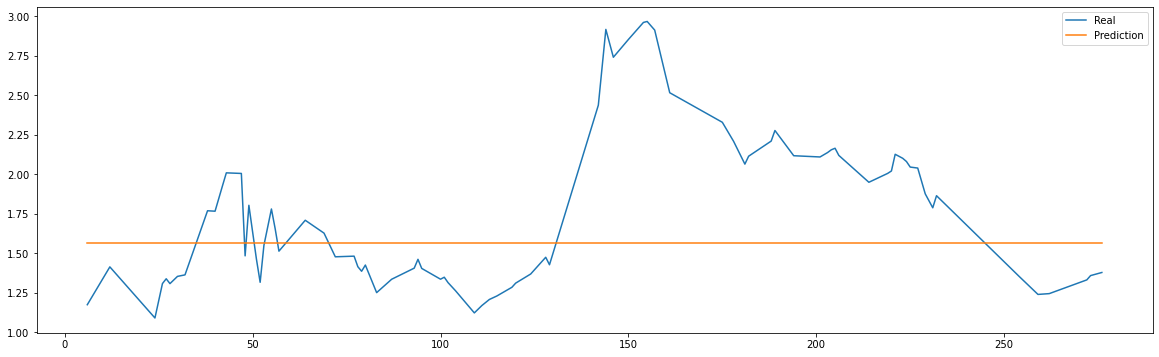

In [97]:
print(MAPE(pred, y_test_ada) * 100, '%')
print(MSE(pred, y_test_ada))
plot_graph(Real = y_test_ada.sort_index(), Prediction = pred.sort_index())

---

<h3>Applying Rolling Forecast</h3>
<p>
    The accuracy of the Control model above is quite bad: 21.27% MAPE, lets try to improve it by using Rolling forecast. The model now makes predictions based on a specific amount of lags, in this case 7 days prior.
</p>

In [98]:
def rolling_control(df: pd.DataFrame, strategy: str = 'mean', window: int = 7 ,test_ratio: float = 0.3) -> pd.DataFrame:
    x_test = df[['low', 'high']][ma.floor(df.shape[0] * (1 - test_ratio)):]
    pred = pd.DataFrame(columns = ['date', 'pred', 'real'])
    model = ControlRegression(strategy = strategy)

    for i in x_test.index:
        x_train = df[['low', 'high']][i - window:i]
        y_train = df['price'][i - window:i]
        model.fit(x_train, y_train)
        pred.loc[i] = {'date': df.loc[i]['date'], 'real': df.loc[i]['price'], 'pred': model.predict(x_test.loc[[i]])[0]}

    return pred.set_index('date')

In [99]:
rolling_ada = rolling_control(df_ada, 'mean', 0.3)

4.938090674888718 %
0.01074860140418951


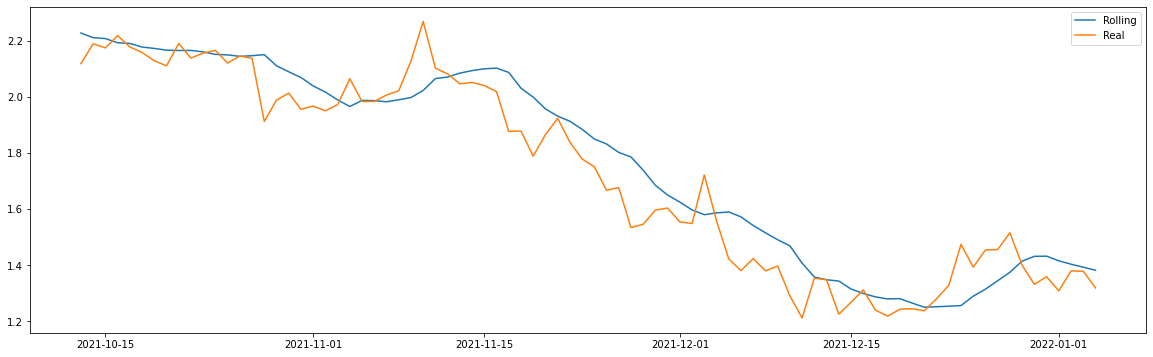

In [100]:
print(MAPE(rolling_ada['pred'], rolling_ada['real']) * 100, '%')
print(MSE(rolling_ada['pred'], rolling_ada['real']))
plot_graph(Rolling = rolling_ada['pred'], Real = rolling_ada['real'])

<p>
    The accuracy improved significantly, now as low as 4.94%, about four times as accurate. 
</p>

---

<h3>ETH</h3>

In [101]:
df_eth = get_csv('./data/ethereum.csv')

In [102]:
eth_rolling = rolling_control(df_eth)

6.381071789544535 %
36771.26988803566


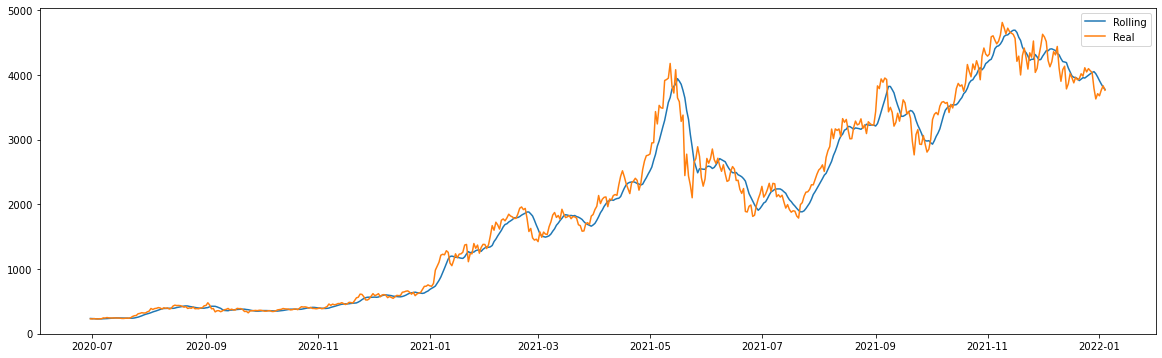

In [103]:
print(MAPE(eth_rolling['pred'], eth_rolling['real']) * 100, '%')
print(MSE(eth_rolling['pred'], eth_rolling['real']))
plot_graph(Rolling = eth_rolling['pred'], Real = eth_rolling['real'])

---

<h3>DOGE</h3>

In [104]:
df_doge = get_csv('./data/dogecoin.csv')

In [105]:
doge_rolling = rolling_control(df_doge)

8.92864570773257 %
0.002211708543439995


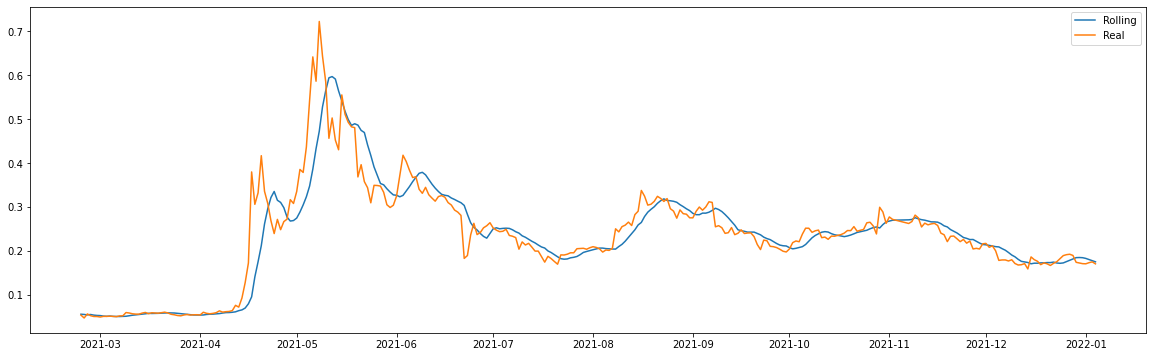

In [106]:
print(MAPE(doge_rolling['pred'], doge_rolling['real']) * 100, '%')
print(MSE(doge_rolling['pred'], doge_rolling['real']))
plot_graph(Rolling = doge_rolling['pred'], Real = doge_rolling['real'])

---

<h3>SOL</h3>

In [107]:
df_sol =  get_csv('./data/solana.csv')

In [108]:
sol_rolling = rolling_control(df_sol)

6.804281743156635 %
189.60694255856922


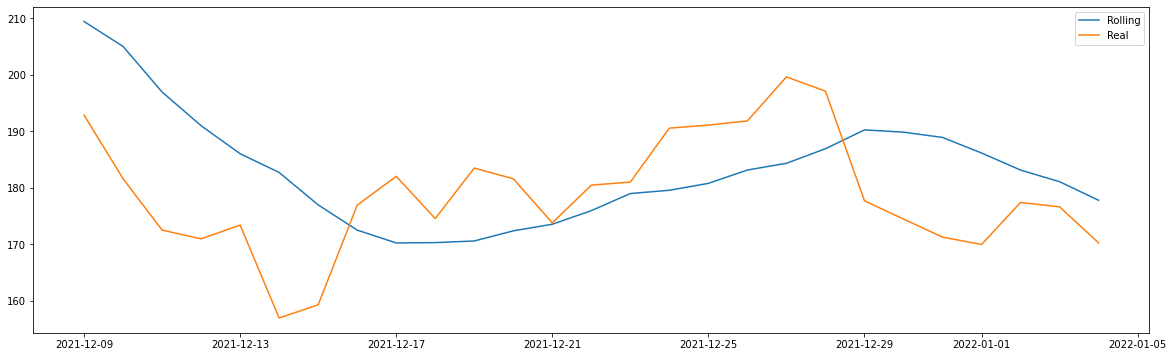

In [109]:
print(MAPE(sol_rolling['pred'], sol_rolling['real']) * 100, '%')
print(MSE(sol_rolling['pred'], sol_rolling['real']))
plot_graph(Rolling = sol_rolling['pred'], Real = sol_rolling['real'])